# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [4]:
2+2

4

In [5]:
!wget https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv

--2019-07-10 23:37:53--  https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4384 (4.3K) [text/plain]
Saving to: ‘drinks.csv’

drinks.csv          100%[===================>]   4.28K  --.-KB/s    in 0s      

2019-07-10 23:37:53 (97.9 MB/s) - ‘drinks.csv’ saved [4384/4384]



In [6]:
!ls

drinks.csv  sample_data


In [7]:
drinks2 = pd.read_csv('drinks.csv')
print(drinks2.shape)

(193, 5)


In [8]:
import pandas as pd
drinks = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv')
print(drinks.shape)
drinks.head()

(193, 5)


,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [9]:
drinks.columns

Index(['country', 'beer_servings', 'spirit_servings', 'wine_servings',
       'total_litres_of_pure_alcohol'],
      dtype='object')

In [10]:
drinks.sort_values('beer_servings', ascending=False).head(10)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
117,Namibia,376,3,1,6.8
45,Czech Republic,361,170,134,11.8
62,Gabon,347,98,59,8.9
65,Germany,346,117,175,11.3
98,Lithuania,343,244,56,12.9
135,Poland,343,215,56,10.9
188,Venezuela,333,100,3,7.7
81,Ireland,313,118,165,11.4
129,Palau,306,63,23,6.9
140,Romania,297,122,167,10.4


       country  beer_servings  ...  total_litres_of_pure_alcohol  drinks_alcohol
0  Afghanistan              0  ...                           0.0            None
1      Albania             89  ...                           4.9             Low
2      Algeria             25  ...                           0.7             Low
3      Andorra            245  ...                          12.4            High
4       Angola            217  ...                           5.9             Low

[5 rows x 6 columns]


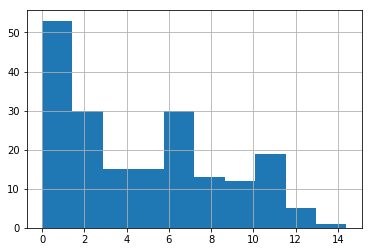

In [11]:
import numpy as np
import matplotlib.pyplot as plt

drinks['drinks_alcohol'] = np.where(drinks['total_litres_of_pure_alcohol'] > 9, 'High',
                           np.where(drinks['total_litres_of_pure_alcohol'] >= 6, 'Medium',
                           np.where(drinks['total_litres_of_pure_alcohol'] == 0, 'None', 'Low')))
print(drinks.head())
drinks.total_litres_of_pure_alcohol.hist()
plt.show()

In [12]:
countries = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
print(countries.shape)
countries.head()


(249, 11)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [13]:
df = pd.merge(drinks, countries[['name', 'region', 'sub-region']], how='left', left_on='country', right_on='name')
df.head(10)

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
0,Afghanistan,0,0,0,0.0,None,Afghanistan,Asia,Southern Asia
1,Albania,89,132,54,4.9,Low,Albania,Europe,Southern Europe
2,Algeria,25,0,14,0.7,Low,Algeria,Africa,Northern Africa
3,Andorra,245,138,312,12.4,High,Andorra,Europe,Southern Europe
4,Angola,217,57,45,5.9,Low,Angola,Africa,Sub-Saharan Africa
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
6,Argentina,193,25,221,8.3,Medium,Argentina,Americas,Latin America and the Caribbean
7,Armenia,21,179,11,3.8,Low,Armenia,Asia,Western Asia
8,Australia,261,72,212,10.4,High,Australia,Oceania,Australia and New Zealand
9,Austria,279,75,191,9.7,High,Austria,Europe,Western Europe


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 9 columns):
country                         193 non-null object
beer_servings                   193 non-null int64
spirit_servings                 193 non-null int64
wine_servings                   193 non-null int64
total_litres_of_pure_alcohol    193 non-null float64
drinks_alcohol                  193 non-null object
name                            167 non-null object
region                          167 non-null object
sub-region                      167 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 15.1+ KB


In [15]:
df.isna().sum()

country                          0
beer_servings                    0
spirit_servings                  0
wine_servings                    0
total_litres_of_pure_alcohol     0
drinks_alcohol                   0
name                            26
region                          26
sub-region                      26
dtype: int64

In [16]:
df[df.region.isna()]

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
20,Bolivia,167,41,8,3.8,Low,NaN,NaN,NaN
21,Bosnia-Herzegovina,76,173,8,4.6,Low,NaN,NaN,NaN
24,Brunei,31,2,1,0.6,Low,NaN,NaN,NaN
28,Cote d'Ivoire,37,1,7,4.0,Low,NaN,NaN,NaN
45,Czech Republic,361,170,134,11.8,High,NaN,NaN,NaN
46,North Korea,0,0,0,0.0,None,NaN,NaN,NaN
47,DR Congo,32,3,1,2.3,Low,NaN,NaN,NaN
79,Iran,0,0,0,0.0,None,NaN,NaN,NaN
92,Laos,62,0,123,6.2,Medium,NaN,NaN,NaN


In [17]:
drinks.at[184, 'country'] = 'United States of America'
drinks.iloc[184]

country                         United States of America
beer_servings                                        249
spirit_servings                                      158
wine_servings                                         84
total_litres_of_pure_alcohol                         8.7
drinks_alcohol                                    Medium
Name: 184, dtype: object

In [18]:
df.region.value_counts()

Africa      48
Asia        40
Europe      37
Americas    27
Oceania     15
Name: region, dtype: int64

In [19]:
df['sub-region'].value_counts()

Sub-Saharan Africa                 42
Latin America and the Caribbean    26
Western Asia                       16
Southern Europe                    12
Northern Europe                     9
Southern Asia                       8
South-eastern Asia                  8
Eastern Europe                      8
Western Europe                      8
Northern Africa                     6
Central Asia                        5
Polynesia                           5
Micronesia                          4
Melanesia                           4
Eastern Asia                        3
Australia and New Zealand           2
Northern America                    1
Name: sub-region, dtype: int64

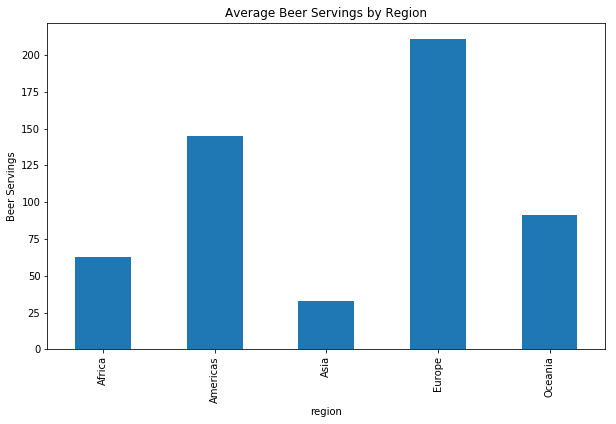

In [20]:
df.groupby('region').beer_servings.mean().plot(kind='bar', figsize=(10,6))
plt.title('Average Beer Servings by Region')
plt.ylabel('Beer Servings')
plt.show()

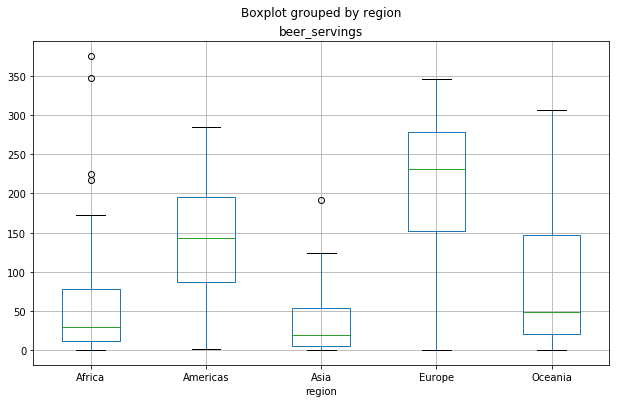

In [21]:
df.boxplot(column='beer_servings', by='region', figsize=(10,6))
plt.show()

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [26]:
import pandas as pd
sffilms = pd.read_csv('https://data.sfgov.org/api/views/yitu-d5am/rows.csv?accessType=DOWNLOAD')
print(sffilms.shape)
sffilms.head()

(1622, 11)


,Title,Release Year,Locations,Fun Facts,Production Company,Distributor,Director,Writer,Actor 1,Actor 2,Actor 3
0,180,2011,Epic Roasthouse (399 Embarcadero),NaN,SPI Cinemas,NaN,Jayendra,"Umarji Anuradha, Jayendra, Aarthi Sriram, & Suba",Siddarth,Nithya Menon,Priya Anand
1,180,2011,Mason & California Streets (Nob Hill),NaN,SPI Cinemas,NaN,Jayendra,"Umarji Anuradha, Jayendra, Aarthi Sriram, & Suba",Siddarth,Nithya Menon,Priya Anand
2,180,2011,Justin Herman Plaza,NaN,SPI Cinemas,NaN,Jayendra,"Umarji Anuradha, Jayendra, Aarthi Sriram, & Suba",Siddarth,Nithya Menon,Priya Anand
3,180,2011,200 block Market Street,NaN,SPI Cinemas,NaN,Jayendra,"Umarji Anuradha, Jayendra, Aarthi Sriram, & Suba",Siddarth,Nithya Menon,Priya Anand
4,180,2011,City Hall,NaN,SPI Cinemas,NaN,Jayendra,"Umarji Anuradha, Jayendra, Aarthi Sriram, & Suba",Siddarth,Nithya Menon,Priya Anand


In [27]:
sffilms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 11 columns):
Title                 1622 non-null object
Release Year          1622 non-null int64
Locations             1568 non-null object
Fun Facts             435 non-null object
Production Company    1620 non-null object
Distributor           1521 non-null object
Director              1622 non-null object
Writer                1617 non-null object
Actor 1               1618 non-null object
Actor 2               1529 non-null object
Actor 3               1150 non-null object
dtypes: int64(1), object(10)
memory usage: 139.5+ KB


In [29]:
sffilms.isna().sum()

Title                    0
Release Year             0
Locations               54
Fun Facts             1187
Production Company       2
Distributor            101
Director                 0
Writer                   5
Actor 1                  4
Actor 2                 93
Actor 3                472
dtype: int64

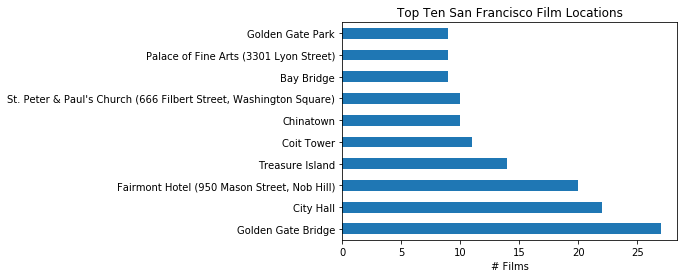

In [36]:
sffilms.Locations.value_counts()[:10].plot(kind='barh')
plt.title('Top Ten San Francisco Film Locations')
plt.xlabel('# Films')
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I wanted to find out what the top ten San Francisco film locations were.  I found a dataset on Data.gov that contained all the film locations in San Francisco.  After reviewing the data, I was able to plot the top ten sites on a graph and as expected the Golden Gate Bridge was number one.  I was suprised that the Fairmont Hotel was in third place.

2.  What was the most challenging part of what you did?

Oddly enough - loading the data!  The data set I used was easy to load, but I explored others such as loading from my local Mac drive, loading from a zip file and loading from Kaggle all without success!

3.  What was the most interesting thing you learned?

I love the graphing (see the next question)

4.  What area would you like to explore with more time?

The graphing is great, but will require far more time and energy to understand all the types and variations.




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.